In [ ]:
import os, sys, copy
import cv2
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Resizing, Rescaling, Input, \
                                    MaxPooling2D, Flatten

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df = pd.DataFrame(columns=['index', 'path'])

In [ ]:
i = 0
for file in sorted(os.listdir(f"/content/drive/MyDrive/CS336/dataset")):
    data_df.loc[i] = [i, f"/content/drive/MyDrive/CS336/dataset/{file}"]
    i += 1

In [ ]:
data_df

,index,path
0,0,/content/drive/MyDrive/CS336/dataset/all_souls...
1,1,/content/drive/MyDrive/CS336/dataset/all_souls...
2,2,/content/drive/MyDrive/CS336/dataset/all_souls...
3,3,/content/drive/MyDrive/CS336/dataset/all_souls...
4,4,/content/drive/MyDrive/CS336/dataset/all_souls...
...,...,...
5058,5058,/content/drive/MyDrive/CS336/dataset/worcester...
5059,5059,/content/drive/MyDrive/CS336/dataset/worcester...
5060,5060,/content/drive/MyDrive/CS336/dataset/worcester...
5061,5061,/content/drive/MyDrive/CS336/dataset/worcester...


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
# base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
# model = Sequential([
#                 # input_layers,
#                 base_model,
#                 MaxPooling2D(strides=(7, 7)),
#                 Flatten()
# ])

# model.build((None, 224, 224, 3))
base_model = VGG16(include_top=True, weights='imagenet')
model = Model(inputs = base_model.input, outputs = base_model.layers[-2].output)
model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
with open('/content/drive/MyDrive/CS336/feature_vectors/VGG_16_4096d_features.npy', 'rb') as f:
    features = np.load(f)

In [ ]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

In [ ]:
def compute_ap(rel, ranked_list):
    ap = 0.0
    precision = 1.0
    intersect_size = 0
    precision_list = []
    j = 0
    for i in range(len(ranked_list)):
        if ranked_list[i] in rel:
            intersect_size += 1
            precision = intersect_size / (j + 1.0)
            precision_list.append(precision)
        j += 1
    ap = np.array(precision_list).mean()
    return ap

In [ ]:
def predict(IMGPATH, kmeans, features):
  query_img = cv2.imread(IMGPATH)
  query_img = cv2.resize(query_img, input_shape[: 2])
  query_img = tf.expand_dims(tf.convert_to_tensor(query_img), axis=0)

  query_features = model.predict(query_img, batch_size=None)

  label_query = kmeans.predict(query_features.astype(np.float32))

  rank_list_features = []
  rank_list_index = []

  for index,label in enumerate(kmeans.labels_,0):
      if label == label_query:
          rank_list_features.append(features[index])
          rank_list_index.append(index)

  sim = []

  for v in zip(rank_list_features, rank_list_index):
      cos_sim = np.dot(query_features, v[0]) / (np.linalg.norm(query_features) * np.linalg.norm(v[0]))
      sim.append((cos_sim,v[1])) 

  relevant_ans = Sort_Tuple(sim)

  return relevant_ans

In [ ]:
def plot_result(IMGPATH, kmeans, features):
  relevant_ans = predict(IMGPATH, kmeans, features)
  for ans in relevant_ans[:len(relevant_ans) // 2]:
      img = cv2.imread(f"{data_df.iloc[ans[1]][1]}")
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

In [ ]:
def compute_mAP(DATAPATH, kmeans, features):
  ap =[] 
  for q in sorted(os.listdir(f"{DATAPATH}/query")): 
    IMGPATH = f"/content/drive/MyDrive/CS336/query/{q}"
    relevant_ans = predict(IMGPATH, kmeans, features)
    ranked_list = []
    for ans in relevant_ans:
      ranked_list.append(f"{data_df.iloc[ans[1]][1]}".split('/')[-1].split('.')[0])

    gt = []
    grd = f"{q[: q.rindex('_')]}.txt"
    with open(f'/content/drive/MyDrive/CS336/gt/{grd}') as gt_f:
        gt = [line.strip() for line in gt_f.readlines()]

    q_ap = compute_ap(gt, ranked_list)
    ap.append(q_ap)
  return np.array(ap).mean()

In [ ]:
DATAPATH = "/content/drive/MyDrive/CS336"

In [ ]:
list_mAP = []
for i in range(50,550, 50):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(features)
  list_mAP.append(compute_mAP(DATAPATH, kmeans, features))

[]

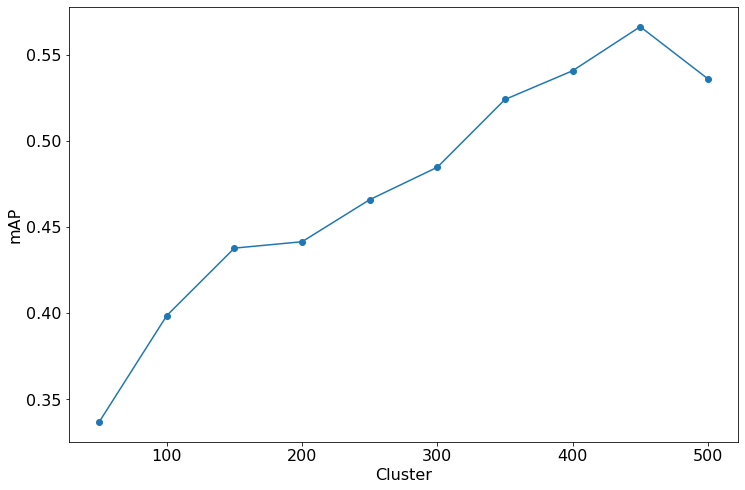

In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(range(50,550,50), list_mAP, marker='o')
plt.xlabel('Cluster')
plt.ylabel('mAP')
plt.plot()

In [ ]:
list_mAP

[0.33683607204550026,
 0.3986042180051963,
 0.4377801780237868,
 0.4414762429043955,
 0.46588739066853047,
 0.4847099829751648,
 0.5240354004126172,
 0.5407009522332569,
 0.5662871638046713,
 0.5360449510126619]

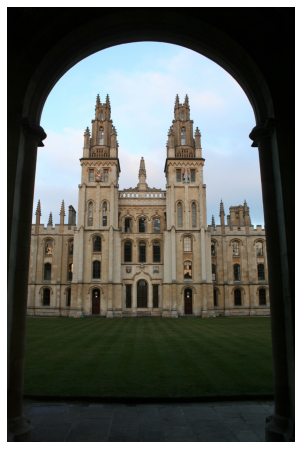

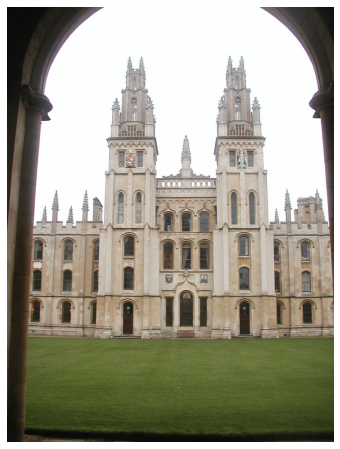

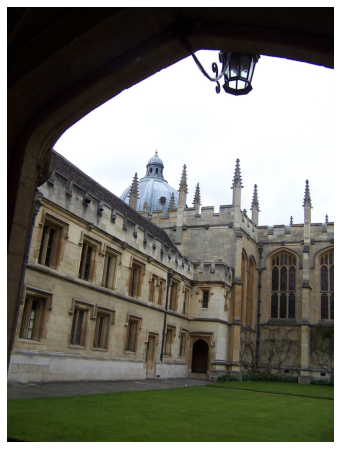

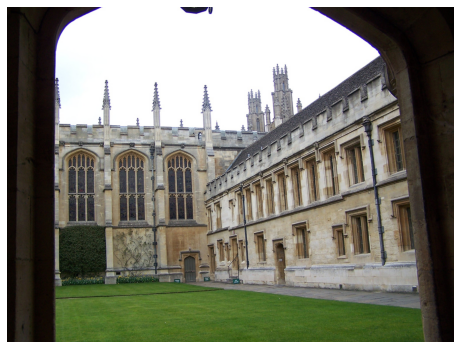

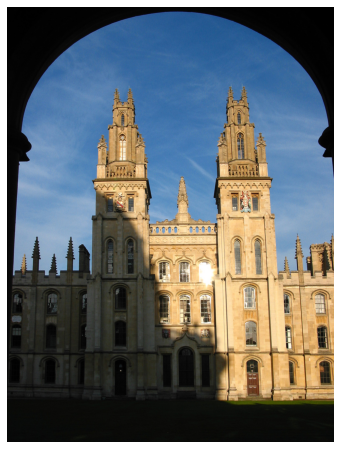

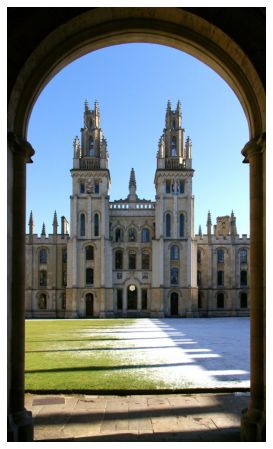

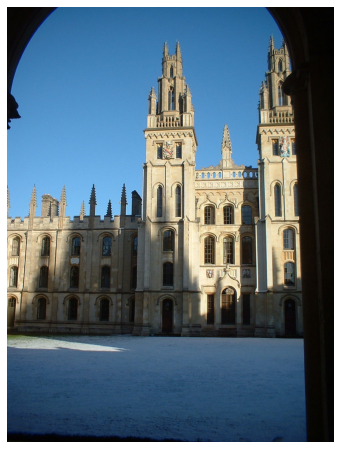

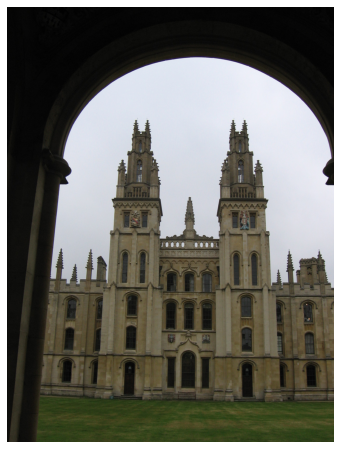

In [ ]:
plot_result("/content/drive/MyDrive/CS336/query/all_souls_3_query.jpg", kmeans, features)